In [1]:
# Set the path to the data directories
train_dir = '../data/chest_xray/train'
val_dir = '../data/chest_xray/val'
test_dir = '../data/chest_xray/test'

In [2]:
# import the necessary packages
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [16]:
image_size = (256, 256)
batch_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [17]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [5]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([64, 3, 256, 256]) torch.Size([64])


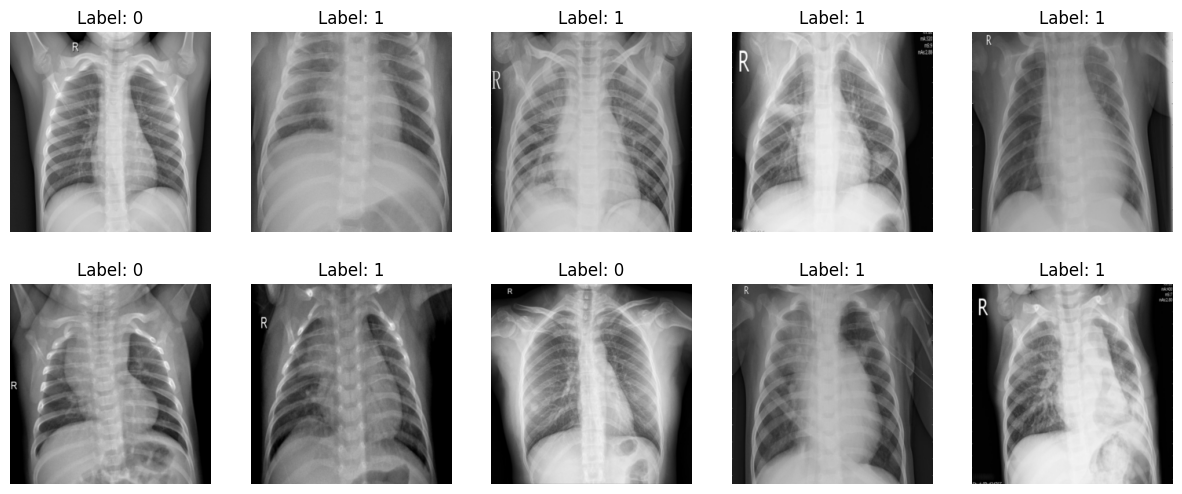

In [6]:
# Example: Iterate through the training data and draw 10 images
for images, labels in train_loader:
    print(images.shape, labels.shape)
    
    # Plot the first 10 images in the batch
    plt.figure(figsize=(15, 6))
    for i in range(10):
        img = images[i].permute(1, 2, 0)  # Change the order of dimensions for plotting
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    break

In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleVGG(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleVGG, self).__init__()
        
        # Define 1 VGG block
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(16 * 128 * 128, 128),  # Adjusted input size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

# Number of classes in your dataset
num_classes = 2  # Change this to match your dataset

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = SimpleVGG(num_classes=num_classes).to(device)

# Print the model architecture
print(model)

SimpleVGG(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=262144, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [12]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
from tqdm import tqdm

# Example: Training loop with validation
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

Training Epoch 1/1: 100%|██████████| 82/82 [03:28<00:00,  2.55s/it]


Epoch [1/1], Loss: 0.3054656520849321


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Validation Loss: 0.6370851993560791, Validation Accuracy: 62.5%


In [15]:
# Save the model's state dictionary
model_path = '../models/baseline_chest_xray.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to ../models/baseline_chest_xray.pth


In [6]:
# test the model
num_classes = 2
model_path = '../deployment/models/baseline_chest_xray.pth'

model = SimpleVGG(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleVGG(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=262144, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

torch.Size([1, 3, 256, 256])


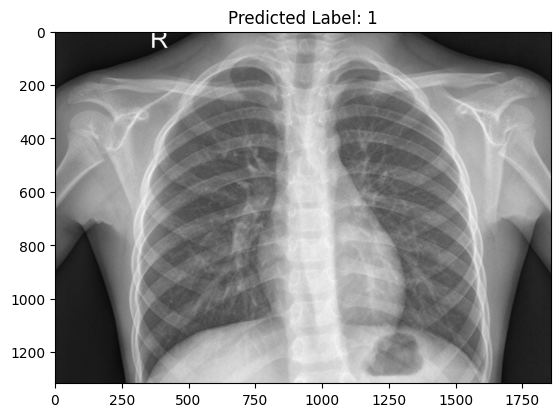

In [5]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the image
image_path = '../data/deployment_test/IM-0001-0001_normal.jpeg'
image = Image.open(image_path).convert('RGB')  # Convert to RGB

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
print(image_tensor.shape)

# Make a prediction
with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.argmax(output, dim=1).item()

# Display the image and the predicted label
plt.imshow(image)
plt.title(f'Predicted Label: {prediction}')
plt.show()